In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install split-folders

# Scenario_01

In [ ]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/DRDO/flowers', output="output", seed=1337, ratio=(.7, .1, .2))

Copying files: 5204 files [01:00, 86.39 files/s] 


In [ ]:
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
# Define data directories
train_dir ="/content/output/train"
test_dir = "/content/output/test"

# Define image dimensions and batch size
img_height = 224
img_width = 224
batch_size = 32

# Create data generators with data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift the width of images
    height_shift_range=0.2,  # Randomly shift the height of images
    horizontal_flip=True,  # Randomly flip images horizontally
    shear_range=0.2,  # Apply shear transformation
    zoom_range=0.2,  # Apply random zoom
    fill_mode='nearest'  # Fill in newly created pixels
)

# Create data generators for validation and test sets (no augmentation)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load and preprocess data using data generators
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # for multi-class classification
)

val_data = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Optionally, you can check the class labels:
class_labels = train_data.class_indices
print(class_labels)


Found 3640 images belonging to 5 classes.
Found 1046 images belonging to 5 classes.
{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
train_data.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [ ]:
images = [train_data[0][0][0] for i in range(25)]
plotImages(images)

In [ ]:
# Define the CNN model
model = models.Sequential()

# Convolutional layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional layer 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output before the fully connected layers
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(5, activation='softmax'))  # 5 classes, so 5 output neurons with softmax activation

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])   # Here we are compiling the model

In [ ]:
checkpoint = ModelCheckpoint(
    'flower_best_model_weights.h5',
    monitor='val_accuracy',  # Choose the metric you want to monitor (e.g., val_loss, val_accuracy)
    save_best_only=True,  # Save only the best model weights
    mode='max',  # 'max' for accuracy, 'min' for loss, 'auto' will automatically infer the mode
    verbose=1  # Display messages about the model saving process
)

In [ ]:
epochs=1

In [ ]:
history = model.fit(
    train_data,
    epochs=epochs,  # Adjust the number of epochs as needed
    validation_data=val_data,
    callbacks=[checkpoint
               ]
)

114/114 [==============================] - ETA: 0s - loss: 1.3048 - accuracy: 0.4668
Epoch 1: val_accuracy improved from -inf to 0.55449, saving model to flower_best_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - 65s 463ms/step - loss: 1.3048 - accuracy: 0.4668 - val_loss: 1.1432 - val_accuracy: 0.5545


In [ ]:
!mv 'apple_best_model_weights.h5' '/content/drive/My Drive/'

mv: cannot stat 'apple_best_model_weights.h5': No such file or directory


In [ ]:
# Load the pretrained model from the end of epoch 1
model.load_weights('/content/flower_best_model_weights.h5')

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training from epoch 2 for an additional 4 epochs
history = model.fit(
    train_data,
    epochs=5,  # 1 previous epochs + 4 additional epochs
    initial_epoch=1,  # Start from epoch 2
    validation_data=val_data,
    callbacks=[checkpoint]  # Include the checkpoint callback if needed
)


Epoch 2/5
114/114 [==============================] - ETA: 0s - loss: 1.1086 - accuracy: 0.5538
Epoch 2: val_accuracy improved from 0.55449 to 0.65010, saving model to flower_best_model_weights.h5
114/114 [==============================] - 54s 458ms/step - loss: 1.1086 - accuracy: 0.5538 - val_loss: 0.9517 - val_accuracy: 0.6501
Epoch 3/5
114/114 [==============================] - ETA: 0s - loss: 1.0074 - accuracy: 0.6033
Epoch 3: val_accuracy did not improve from 0.65010
114/114 [==============================] - 53s 463ms/step - loss: 1.0074 - accuracy: 0.6033 - val_loss: 1.0538 - val_accuracy: 0.5679
Epoch 4/5
114/114 [==============================] - ETA: 0s - loss: 0.9446 - accuracy: 0.6313
Epoch 4: val_accuracy did not improve from 0.65010
114/114 [==============================] - 51s 451ms/step - loss: 0.9446 - accuracy: 0.6313 - val_loss: 1.0469 - val_accuracy: 0.6214
Epoch 5/5
114/114 [==============================] - ETA: 0s - loss: 0.8973 - accuracy: 0.6552
Epoch 5: val_ac

In [ ]:
history.history

{'loss': [1.1085699796676636,
  1.0074057579040527,
  0.9446437358856201,
  0.8972501158714294],
 'accuracy': [0.5538461804389954,
  0.60329669713974,
  0.6313186883926392,
  0.6552197933197021],
 'val_loss': [0.9517207741737366,
  1.0537605285644531,
  1.046915888786316,
  0.8079079985618591],
 'val_accuracy': [0.6500955820083618,
  0.5678776502609253,
  0.6214148998260498,
  0.7141491174697876]}

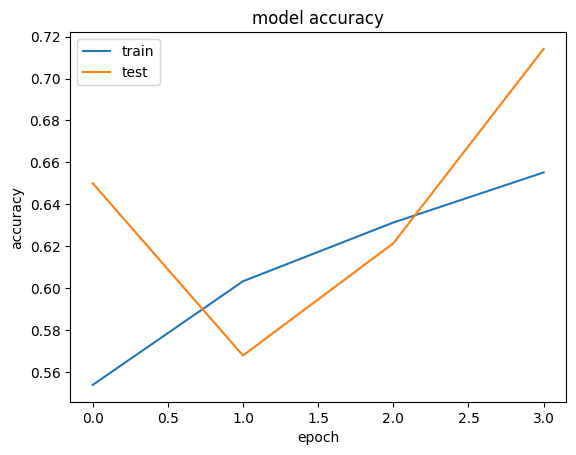

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

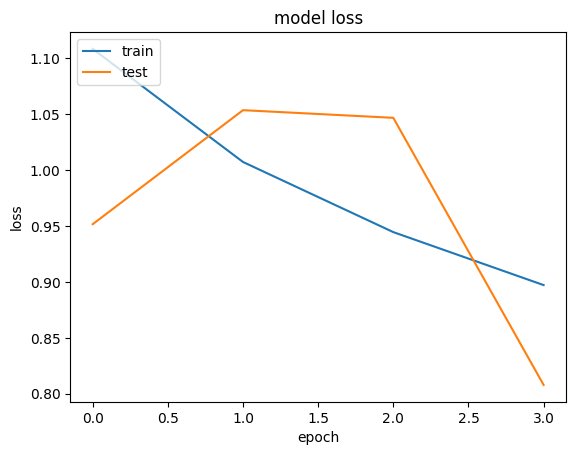

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Load the weights of the best model (assuming you have already saved them)
model.load_weights("/content/flower_best_model_weights.h5")  # Replace with the actual file path

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(val_data)

# Print the accuracy for the best model
print(f'Accuracy of the best model on the test dataset:  {test_accuracy * 100:.2f}%')


33/33 [==============================] - 3s 73ms/step - loss: 0.8079 - accuracy: 0.7141
Accuracy of the best model on the test dataset:  71.41%


In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Directory paths for train and test data
train_dir = train_dir
test_dir = test_dir

# Load the model
model = load_model('/content/flower_best_model_weights.h5')

# Define image data generators for test data
test_data_gen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Adjust to your image size
    batch_size=32,            # Adjust as needed
    class_mode='categorical',  # For classification
    shuffle=False              # Do not shuffle for evaluation
)

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels (assuming one-hot encoding)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = test_generator.classes

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Calculate specificity (true negative rate)
'''tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
specificity = tn / (tn + fp)'''
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate specificity for each class
specificity = []
for i in range(cm.shape[0]):
    true_negative = sum(cm[j][j] for j in range(cm.shape[0])) - cm[i].sum()
    false_positive = cm[:, i].sum() - cm[i][i]
    specificity_i = true_negative / (true_negative + false_positive)
    specificity.append(specificity_i)

# Calculate the average specificity
average_specificity = np.mean(specificity)

# Print the results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Average Specificity: {average_specificity:.2f}')


Found 1046 images belonging to 5 classes.
33/33 [==============================] - 2s 73ms/step
Precision: 0.70
Recall: 0.68
F1 Score: 0.67
Average Specificity: 0.90


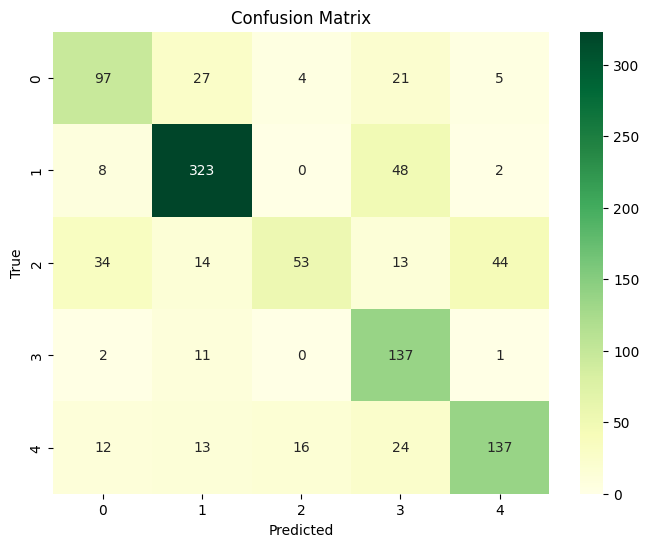

In [ ]:
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGn')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Integrating with the application

We can integrate this model with the application using flask or Django frameworks.

The user can take the photo of the flower and then upload the image with the app which will be sent to the model using the api and then the model will predict the input image and then send it back to the user.
